# On Areas on Earth

Tyler Erickson  
2024-08-17

In recent years, there has been an explosion of high-resolution raster
datasets that characterize the Earth’s surface. An example of this is
the [Global map of Forest Cover for year
2020](https://forest-observatory.ec.europa.eu/forest) (GFC2020).

<figure>
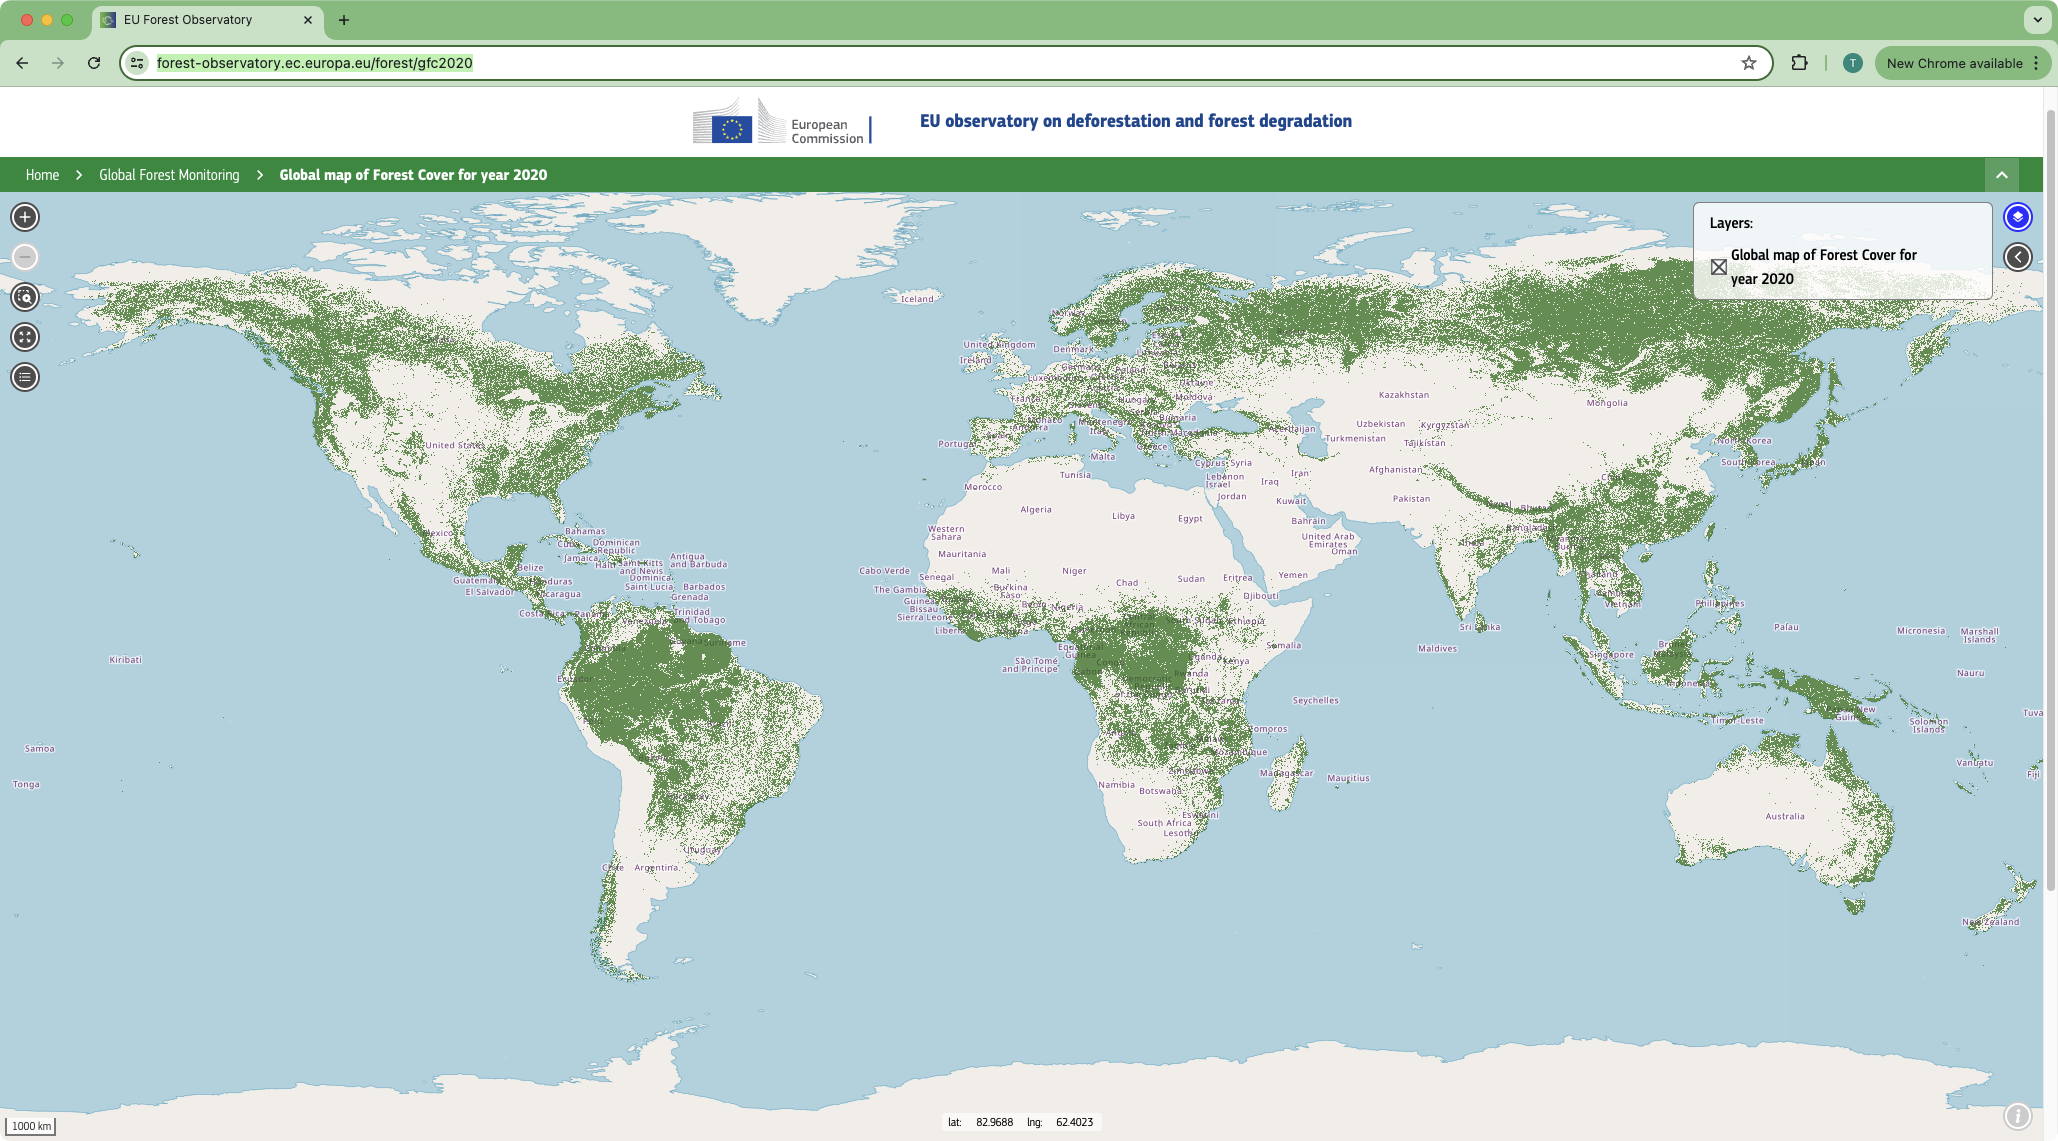
<figcaption aria-hidden="true">Global map of Forest Cover for year 2020,
produced by the European Union Joint Research Centre. <a
href="https://forest-observatory.ec.europa.eu/forest/gfc2020">Click
here</a> to interactively explore dataset on the live
website.</figcaption>
</figure>

The GFC2020 dataset is described as serving to *“define the extent of
tree cover for year 2020 at 10 m spatial resolution”*[1], and it shows
variations in forested land in great detail. However, using the dataset
to accurately answer a seemingly simple question can be quite
challenging. For example:

What is the total area of forest in Iceland?

To determine the total area, can’t we just simply count up the forest
pixels and multiply by 10m squared?

$$A_{forest} = n_{forest pixels} \cdot (10m)^2 $$

> **Short answer:**
>
> Nope.

> **Longer answer: (click to expand)**
>
> There are at least two problems with that approach.
>
> 1.  The GFC2020 dataset uses a coordinate reference system (CRS) of
>     [EPSG:4326](https://epsg.org/crs_4326/WGS-84.html). This is a
>     fairly common CRS used by global datasets. EPSG:4326 has axes of
>     [geodetic latitude and geodetic
>     longitude](https://en.wikipedia.org/wiki/Geodetic_coordinates)
>     measured in **units of degrees**, which is an angle measurement.
>     Typically, the area of something on the Earth’s surface is not
>     measured in unit of degrees squared, but rather a unit of length
>     squared[2].
>
>     With a little sleuthing[3] it can be determined that the unit of
>     measure is an angle in degrees:
>
>         AXIS["geodetic latitude (Lat)",north,
>           ORDER[1],
>           ANGLEUNIT["degree",0.0174532925199433]],
>         AXIS["geodetic longitude (Lon)",east,
>           ORDER[2],
>           ANGLEUNIT["degree",0.0174532925199433]],
>
>     and that the pixel size is much smaller than a degree:
>
>         Pixel Size = (0.000089831528412,-0.000089831528412)
>
>     These angles can be converted to distances, but the [length of a
>     degree of longitude varies with
>     latitude](https://en.wikipedia.org/wiki/Longitude#Length_of_a_degree_of_longitude).
>
> 2.  The surface area of a sphere (or ellipsoid) bulges out, so it is
>     greater than a planar area between the same boundaries. The
>     difference becomes more signficant as the curvature increases. For
>     more details, read up on [spherical
>     excess](https://en.wikipedia.org/wiki/Spherical_trigonometry#From_latitude_and_longitude).

What about using a library to reproject the raster image to an
[equal-area
projection](https://en.wikipedia.org/wiki/Equal-area_projection)? That
may be a viable solution, but the data will be altered by
[resampling](https://gisgeography.com/raster-resampling/) (usually
nearest neighbor resampling for categorical data), which changes the
resulting area calculation[4]. And it may be challenging from a
computation and storage standpoint, depending on the size of dataset.
And you will need to install a projection library, which a complication
that I would like to avoid.

So how can you go about accurately determining the areas of regions on
the Earth’s surface? That’s what this post will cover, at least for a
certain class of rectangular areas. We’ll start with the relevant
mathematical equations and show how they can be implemented with
standard Python libraries.

> **Note: Alternative options**
>
> There are many software libraries and tools that can help with
> calculating areas on the Earth. Many are based on the open source
> [PROJ](https://proj.org/) software, which provides generic coordinate
> transformation functionality via both command line applications and an
> API to power higher-level tools such as [GDAL](https://gdal.org/),
> [pyproj](https://pyproj4.github.io/),
> [Rasterio](https://rasterio.readthedocs.io/),
> [GeoPandas](https://geopandas.org/), [PostGIS](https://postgis.net/),
> [QGIS](https://www.qgis.org/), and many, many more… **use them if you
> can!** These tools are far more flexible (and rigorously tested) than
> the approach I describe here. However, that flexibility results in a
> [complicated codebase](https://github.com/OSGeo/PROJ) which few people
> understand (and can [contribute
> to](https://github.com/OSGeo/PROJ/graphs/contributors)). Even if open
> source, they are [black box](https://en.wikipedia.org/wiki/Black_box)
> systems for most people. This post attempts to transparently explain
> the “how”, but for a very narrow slice of functionality provided by
> PROJ-based tools.

# Areas on the Earth

This post shows how to calculate areas for datasets/images that use a
[(normal) cylindrical
projection](https://en.wikipedia.org/wiki/Map_projection#Normal_cylindrical).
This class of projections has axes aligned with lines of constant
latitude and longitude, and it includes commonly used projections such
as the [plate carrée /
equirectangular](https://en.wikipedia.org/wiki/Equirectangular_projection)[5]
and the [web
Mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection)[6]
projection.

So let’s start off by importing the Python libraries that we will be
using:

[1] I really dislike when the term “resolution” is used instead of pixel
size, but I’ll leave that discussion for another time…

[2] But that doesn’t stop [ChatGPT from
trying](https://chatgpt.com/share/e53e010a-1cab-4b9b-a4fc-8db6944dc91f)!

[3] Strangely, neither the website nor the [publication describing the
dataset](https://publications.jrc.ec.europa.eu/repository/handle/JRC136960)
list the actual pixel size. To determine it, I ended up using the
command line program `gdalinfo` to inspect a sample tile obtained via
the [download page](https://forobs.jrc.ec.europa.eu/GFC#data_download).

[4] The sensitivity of accuracy to reprojection might be worth exploring
in a future post.

[5] a.k.a. the lat/lon projection or *unprojected* projection

[6] the de facto standard for web mapping applications

In [5]:
import math
import numpy as np

## Modeling the Earth

Nowadays, the Earth as commonly modeled as an oblate spheroid[1] also
known as the [reference
ellipsoid](https://en.wikipedia.org/wiki/Earth_ellipsoid#Reference_ellipsoid).
The [equation for a spheroid](https://en.wikipedia.org/wiki/Spheroid)
is:

$${\displaystyle {\frac {x^{2}+y^{2}}{a^{2}}}+{\frac {z^{2}}{c^{2}}}=1}$$

where $a$ is the equitorial radius, and $c$ is the distance from the
center to the pole.

<figure>
<img
src="https://upload.wikimedia.org/wikipedia/commons/5/53/Ellipsoid-rot-ax.svg"
alt="An ellipsoid / spheroid. Creative Commons Attribution 4.0 International License Source: Wikimedia Commons" />
<figcaption aria-hidden="true">An ellipsoid / spheroid. <img
src="https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by.svg"
alt="Creative Commons Attribution 4.0 International License" /> Source:
<a
href="https://commons.wikimedia.org/wiki/File:Ellipsoid-rot-ax.svg">Wikimedia
Commons</a></figcaption>
</figure>

For an oblate spherioid (like the Earth), $c < a$ and the flattening
($f$) is [defined](https://en.wikipedia.org/wiki/Flattening) as:
$$f=\frac {a-c}{a}$$

The Earth is most commonly modeled using the world geodetic system [WGS
84](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS_84)
reference ellipsoid, which is defined with the following parameters:

[1] i.e. a flattened sphere

In [6]:
a = 6378137.0  # m, semi-major axis (equatorial radius)
f = 1 / 298.257223563  # flattening

Solving for the semi-minor axis of the ellipsoid, $c$ gives:
$$c = a \cdot (1 - f)$$

which results in:

In [7]:
c = a * (1 - f)  # m, semi-minor axis
print(f'semi-minor axis, c = {c:.6f} meters')

semi-minor axis, c = 6356752.314245 meters

It is also helpful to calculate the ellipsoid’s
[eccentricity](https://en.wikipedia.org/wiki/Latitude#The_geometry_of_the_ellipsoid)
value, which is defined as:

$$e^{2}=2f-f^{2}$$

In [8]:
e2 = 2 * f - f**2
e = math.sqrt(e2)

print(f'e2 = {e2}')
print(f'e = {e}')

e2 = 0.0066943799901413165
e = 0.08181919084262149

## Surface Area

Now that we have characterised the ellipsoid, we can [calculate the
surface area](https://en.wikipedia.org/wiki/Spheroid#Area) with:

$$A_{\text{oblate}}=2\pi a^{2}\ +{\frac {\pi c^{2}}{e}}\ln {\frac {1+e}{1-e}}$$

For the WGS84 ellipsoid parameters, this gives us a surface area of:

In [9]:
A_oblate = 2 * math.pi * a**2 + math.pi * c**2 / e * math.log((1 + e) / (1 - e))
print(f'Earth surface area = {A_oblate / 1e6:.6f} km^2')

Earth surface area = 510065621.724088 km^2

… which is close to the value of 510072000 km<sup>2</sup> [listed on
Wikipedia](https://en.wikipedia.org/wiki/Earth).

Since calculating for a sphere is more straightforward than calculations
for an ellipsoid, we solve for the radius of a spherical model that has
the same surface area as the ellipsoid model. This radius is called the
[authalic
radius](https://en.wikipedia.org/wiki/Earth_radius#Authalic_radius)
($R_2$)

$$R_2 = \sqrt{\frac{A_{\text{oblate}}}{4 \pi}}$$

In [10]:
R_auth = math.sqrt(A_oblate / 4 / math.pi)
print(f'authalic radius (R_auth) = {R_auth:.6f} meters')

authalic radius (R_auth) = 6371007.180918 meters

For area segments between two bands of constant latitudes ($\phi_1$ and
$\phi_2$), the [Spherical segment
formula](https://en.wikipedia.org/wiki/Spherical_segment) can be used.
The curved surface area of the spherical zone between two latitudes is
given by: $$
A_{\text{zone}} = 2 \pi R_2 h
$$

where $h$ is the height of the segment:
<span id="eq-height-spherical-segment">$$
h = R_2 (\sin \phi_2 - \sin \phi_1)
 \qquad(1)$$</span>

Constraining the area to be a patch ($A_{\text{patch}}$) between
longitudes ($\lambda_1 <= \lambda <= \lambda_2$) gives:

<span id="eq-area-patch-lon-band">$$
\begin{aligned}
A_{\text{patch}} &= A_{\text{zone}} \frac{\lambda_2 - \lambda_1}{2 \pi} \\ 
                 &= R_2 h (\lambda_2 - \lambda_1)
\end{aligned}
 \qquad(2)$$</span>

Written as a Python function:

In [11]:
def patch_area_single_rectangle(
    R: float, # Authalic radius, in meters
    lon1: float, # Minimum longitude, in degrees
    lon2: float, # Maximum longitude, in degrees
    lat1: float, # Minimum latitude, in degrees
    lat2: float, # Maximum latitude, in degrees
) -> float:
    # Convert from degrees to radians
    lon1_rad = lon1 * (np.pi / 180)
    lon2_rad = lon2 * (np.pi / 180)
    lat1_rad = lat1 * (np.pi / 180)
    lat2_rad = lat2 * (np.pi / 180)
    
    h = R * (math.sin(lat2_rad) - math.sin(lat1_rad))
    area_patch = R * h  * (lon2_rad - lon1_rad)
    return area_patch

We can try this function out for a few patches:

In [12]:
print(f'{(patch_area_single_rectangle(R=R_auth, lon1=-180, lon2=180, lat1=-90, lat2=90)*1e-6):.3e} km^2 is the area of the globe')
print(f'{(patch_area_single_rectangle(R=R_auth, lon1=0, lon2=180, lat1=-90, lat2=90)*1e-6):.3e} km^2 is the area of a (eastern) hemisphere')
print(f'{(patch_area_single_rectangle(R=R_auth, lon1=0, lon2=10, lat1=-90, lat2=90)*1e-6):.3e} km^2 is the area of a 10 degree longitude band')
print(f'{(patch_area_single_rectangle(R=R_auth, lon1=0, lon2=10, lat1=0, lat2=10)*1e-6):.3e} km^2 is the area of a 10 x 10 degree patch')

5.101e+08 km^2 is the area of the globe
2.550e+08 km^2 is the area of a (eastern) hemisphere
1.417e+07 km^2 is the area of a 10 degree longitude band
1.230e+06 km^2 is the area of a 10 x 10 degree patch

This works for single patches, but we can adapt the function to
efficiently estimate a (potentially irregular) grid of patches by
accepting lists of latitude edges and longitudes edges:

$$\boldsymbol{A}_{patch} = \boldsymbol{w} \cdot \boldsymbol{h}^T$$
$$\boldsymbol{w} = R_2 (\boldsymbol{\lambda}_2 - \boldsymbol{\lambda}_1)$$
$$\boldsymbol{h} = R_2 (\sin \boldsymbol{\phi}_2 - \sin \boldsymbol{\phi}_1)$$

In [13]:
def patch_area(
    R: float, # Authalic radius, in meters
    lon_edges: list[float], # longitude edges, in degrees
    lat_edges: list[float] # latitude edges, in degrees
) -> list[list[float]]:
    # Convert from degrees to radians
    lon_min = np.array(lon_edges[:-1]) * (np.pi / 180)
    lon_max = np.array(lon_edges[1:]) * (np.pi / 180)
    lat_min = np.array(lat_edges[:-1]) * (np.pi / 180)
    lat_max = np.array(lat_edges[1:]) * (np.pi / 180)
    h = np.reshape(
        R * (np.sin(lat_max) - np.sin(lat_min)),
        newshape=(-1, 1)
    )
    w = np.reshape(
        R * (lon_max - lon_min),
        newshape=(-1, 1)
    )
    area_patch = (w @ h.T).T  # matrix multiplication (@ is * for mATrices)
    return area_patch

Let’s try it out, displaying the results on a globe:

In [14]:
lon_edges = range(-180, 180 + 1, 10)
lat_edges = range(-90, 90 + 1, 10)
areas = patch_area(R_auth, lon_edges, lat_edges)

# print(f'areas = {(areas * 1e-6)} km^2')
print(f'Total area = {(areas.sum() * 1e-6):.6G} km^2')

Total area = 5.10066E+08 km^2

In [15]:
import pydeck as pdk

default_view_state = pdk.ViewState(
    latitude=45,
    longitude=np.average(lon_edges),
    zoom=0,
    min_zoom=0,
)

view = pdk.View(
    type="_GlobeView",
    controller=True,
    width='100%',
)

basemap_layer = pdk.Layer(
    "GeoJsonLayer",
    id="base-map",
    data="https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_scale_rank.geojson",
    stroked=False,
    filled=True,
    extruded=False,
    get_fill_color=[200, 200, 200],
    get_line_color=[255, 255, 255],
)

elevation = 1e5

layer_data = [
    {
        "Longitude range": f'({lon_edges[ix]},{lon_edges[ix + 1]})',
        "Latitude range":  f'({lat_edges[iy]},{lat_edges[iy + 1]})',
        "coordinates": [
            [lon_edges[ix], lat_edges[iy], elevation],
            [lon_edges[ix], lat_edges[iy+1], elevation],
            [lon_edges[ix+1], lat_edges[iy+1], elevation],
            [lon_edges[ix+1], lat_edges[iy], elevation],
            [lon_edges[ix], lat_edges[iy], elevation]
        ]
    }
    for iy, lat in enumerate(lat_edges[:-1])
    for ix, lon in enumerate(lon_edges[:-1])
]

# Append the calculated area.
layer_data = [
    dict(d, area=f'{areas.flatten()[i] * 1e-6:.6g}')
    for i, d in enumerate(layer_data)
]

polygon_layer = pdk.Layer(
    "SolidPolygonLayer",
    layer_data,
    visible=True,
    get_polygon="coordinates",
    filled=True,
    extruded=True,
    wireframe=True,
    get_fill_color=[255, 255, 0, 127],
    get_line_color=[255, 0, 0],
    auto_highlight=True,
    pickable=True,
    picking_radius=10,
)

tooltip = {"html": (
    "<b>Longitude range:</b> {Longitude range}<br />"
    "<b>Latitude range:</b> {Latitude range}<br />"
    "<b>Area:</b> {area} km^2"
)}

deck = pdk.Deck(
    views=[view],
    initial_view_state=default_view_state,
    layers=[
        basemap_layer,
        polygon_layer,
    ],
    map_provider=None,
    tooltip=tooltip,
    # Note: set to True for the globe to be opaque
    parameters={"cull": True},
)

deck

<iframe
 width="100%"
 height=500
 frameborder="0"
 srcdoc="<!DOCTYPE html>
<html>
 <head>
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 <title>pydeck</title>
 <script src="https://api.tiles.mapbox.com/mapbox-gl-js/v1.13.0/mapbox-gl.js"></script>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css" />
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css" />
 <script src='https://cdn.jsdelivr.net/npm/@deck.gl/jupyter-widget@~8.8.*/dist/index.js'></script>
 <style>
 body {
 margin: 0;
 padding: 0;
 overflow: hidden;
}

#deck-container {
 width: 100vw;
 height: 100vh;
}

#deck-container canvas {
 z-index: 1;
 background: none;
}
 </style>
 </head>
 <body>
 <div id="deck-container">
 </div>
 </body>
 <script>
 const container = document.getElementById('deck-container');
 const jsonInput = {
 "initialViewState": {
 "latitude": 45,
 "longitude": 0.0,
 "minZoom": 0,
 "zoom": 0
 },
 "layers": [
 {
 "@@type": "GeoJsonLayer",
 "data": "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_scale_rank.geojson",
 "extruded": false,
 "filled": true,
 "getFillColor": [
 200,
 200,
 200
 ],
 "getLineColor": [
 255,
 255,
 255
 ],
 "id": "base-map",
 "stroked": false
 },
 {
 "@@type": "SolidPolygonLayer",
 "autoHighlight": true,
 "data": [
 {
 "Latitude range": "(-90,-80)",
 "Longitude range": "(-180,-170)",
 "area": "107626",
 "coordinates": [
 [
 -180,
 -90,
 100000.0
 ],
 [
 -180,
 -80,
 100000.0
 ],
 [
 -170,
 -80,
 100000.0
 ],
 [
 -170,
 -90,
 100000.0
 ],
 [
 -180,
 -90,
 100000.0
 ]
 ]
 },
 {
 "Latitude range": "(-90,-80)",
 "Longitude range": "(-170,-160)",
 "area": "107626",
 "coordinates": [
 [
 -170,
 -90,
 100000.0
 ],
 [
 -170,
 -80,
 100000.0
 ],
 [
 -160,
 -80,
 100000.0
 ],
 [
 -160,
 -90,
 100000.0
 ],
 [
 -170,
 -90,
 100000.0
 ]
 ]
 },
 {
 "Latitude range": "(-90,-80)",
 "Longitude range": "(-160,-150)",
 "area": "107626",
 "coordinates": [
 [
 -160,
 -90,
 100000.0
 ],
 [
 -160,
 -80,
 100000.0
 ],
 [
 -150,
 -80,
 100000.0
 ],
 [
 -150,
 -90,
 100000.0
 ],
 [
 -160,
 -90,
 100000.0
 ]
 ]
 },
 {
 "Latitude range": "(-90,-80)",
 "Longitude range": "(-150,-140)",
 "area": "107626",
 "coordinates": [
 [
 -150,
 -90,
 100000.0
 ],
 [
 -150,
 -80,
 100000.0
 ],
 [
 -140,
 -80,
 100000.0
 ],
 [
 -140,
 -90,
 100000.0
 ],
 [
 -150,
 -90,
 100000.0
 ]
 ]
 },
 {
 "Latitude range": "(-90,-80)",
 "Longitude range": "(-140,-130)",
 "area": "107626",
 "coordinates": [
 [
 -140,
 -90,
 100000.0
 ],
 [
 -140,
 -80,
 100000.0
 ],
 [
 -130,
 -80,
 100000.0
 ],
 [
 -130,
 -90,
 100000.0
 ],
 [
 -140,
 -90,
 100000.0
 ]
 ]
 },
 {
 "Latitude range": "(-90,-80)",
 "Longitude range": "(-130,-120)",
 "area": "107626",
 "coordinates": [
 [
 -130,
 -90,
 100000.0
 ],
 [
 -130,
 -80,
 100000.0
 ],
 [
 -120,
 -80,
 100000.0
 ],
 [
 -120,
 -90,
 100000.0
 ],
 [
 -130,
 -90,
 100000.0
 ]
 ]
 },
 {
 "Latitude range": "(-90,-80)",
 "Longitude range": "(-120,-110)",
 "area": "107626",
 "coordinates": [
 [
 -120,
 -90,
 100000.0
 ],
 [
 -120,
 -80,
 100000.0
 ],
 [
 -110,
 -80,
 100000.0
 ],
 [
 -110,
 -90,
 100000.0
 ],
 [
 -120,
 -90,
 100000.0
 ]
 ]
 },
 {
 "Latitude range": "(-90,-80)",
 "Longitude range": "(-110,-100)",
 "area": "107626",
 "coordinates": [
 [
 -110,
 -90,
 100000.0
 ],
 [
 -110,
 -80,
 100000.0
 ],
 [
 -100,
 -80,
 100000.0
 ],
 [
 -100,
 -90,
 100000.0
 ],
 [
 -110,
 -90,
 100000.0
 ]
 ]
 },
 {
 "Latitude range": "(-90,-80)",
 "Longitude range": "(-100,-90)",
 "area": "107626",
 "coordinates": [
 [
 -100,
 -90,
 100000.0
 ],
 [
 -100,
 -80,
 100000.0
 ],
 [
 -90,
 -80,
 100000.0
 ],
 [
 -90,
 -90,
 100000.0
 ],
 [
 -100,
 -90,
 100000.0
 ]
 ]
 },
 {
 "Latitude range": "(-90,-80)",
 "Longitude range": "(-90,-80)",
 "area": "107626",
 "coordinates": [
 [
 -90,
 -90,
 100000.0
 ],
 [
 -90,
 -80,
 100000.0
 ],
 [
 -80,
 -80,
 100000.0
 ],
 [
 -80,
 -90,
 100000.0
 ],
 [
 -90,
 -90,
 10000

> **Hint**
>
> The globe is interactive. Roll your cursor over the patches to see the
> calculation results. Click and drag to rotate the globe.

# Wrapping up

In this post I’ve presented an approach for calculating patch areas on
the Earth’s surface. In a future post I’ll expand on this to calculate
the areas of every pixel in a projected image.